In [3]:
import numpy as np
from sklearn.datasets import fetch_openml

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist)

In [10]:
X, y = mnist['data'], mnist['target']

In [11]:
X.shape

(70000, 784)

In [13]:
y.shape

(70000,)

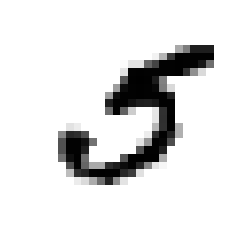

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')

plt.axis('off')

plt.show()



In [23]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
np.histogram(y_test, bins=9)


(array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028, 1983], dtype=int64),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]))

In [55]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [57]:
sgd_clf.predict([some_digit])

array([False])

In [30]:
y_pred = sgd_clf.predict(X_test)

sum(y_pred == y_test_5)

sum(y_pred != y_test_5)

325

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))
    

0.89345
0.75235
0.7899


In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.89345, 0.75235, 0.7899 ])

In [39]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([1.     , 0.72895, 1.     ])

In [44]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[44363, 10216],
       [ 1070,  4351]], dtype=int64)

In [43]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_train_pred))

print(recall_score(y_train_5, y_train_pred))

print(f1_score(y_train_5, y_train_pred))

0.298688817189538
0.8026194429072127
0.43536121673003797


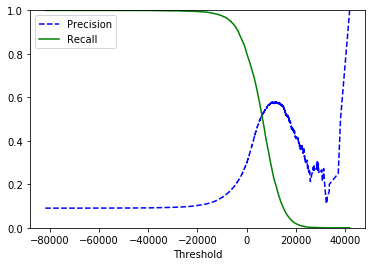

In [54]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


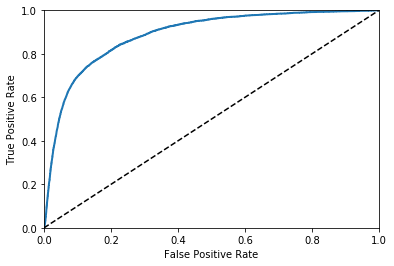

In [63]:
# The ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    
plot_roc_curve(fpr, tpr)
plt.show()

In [58]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)


0.8873322501447319

In [59]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

C:\Users\Han\Anaconda3\envs\sklearn\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Han\Anaconda3\envs\sklearn\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Han\Anaconda3\envs\sklearn\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


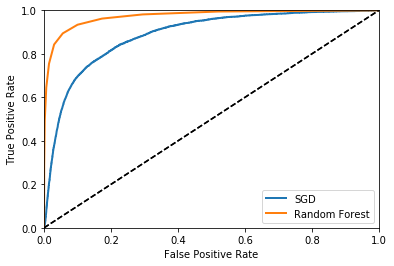

0.9727987276449468

In [65]:
y_scores_forest = y_probas_forest[:,1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plot_roc_curve(fpr, tpr, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend()
plt.show()

roc_auc_score(y_train_5, y_scores_forest)



In [66]:
# Multiclass Classification

sgd_clf.fit(X_train, y_train)

sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [68]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  -382.52170284, -19072.60630422,  -9215.51671077,
         -3736.60589967, -16120.01135804,    274.63843662,
        -18156.66165997,  -7056.62587109, -10653.83889191,
        -10196.1448461 ]])

In [69]:
np.argmax(some_digit_scores)

5

In [70]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

ovo_clf.fit(X_train, y_train)

ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [77]:
ovo_clf.decision_function([some_digit])

array([[7.33333312, 2.66666711, 5.33333204, 8.33333306, 2.66666712,
        9.33333314, 0.66666684, 5.33332167, 1.66666716, 1.66666712]])

In [79]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88097381, 0.86139307, 0.88028204])

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90021996, 0.88989449, 0.90348552])

In [81]:
# Error Analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)

[[5573    0   21    7    9   46   37    6  223    1]
 [   0 6401   37   24    4   44    4    7  211   10]
 [  27   25 5217   94   71   27   68   37  382   10]
 [  22   17  115 5234    2  211   27   40  392   71]
 [  12   14   39   11 5187   12   35   25  340  167]
 [  26   15   28  171   52 4462   74   15  518   60]
 [  30   16   39    3   42   94 5563    3  127    1]
 [  20   10   50   29   51   12    3 5687  185  218]
 [  17   62   44   88    3  130   26   10 5429   42]
 [  22   18   30   65  117   35    1  176  366 5119]]


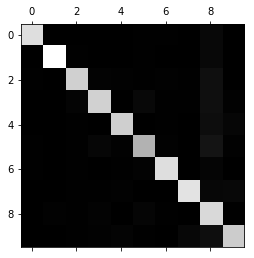

In [84]:
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

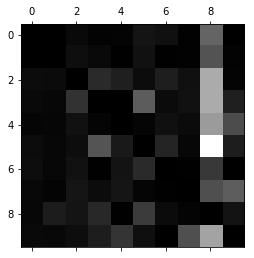

In [85]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

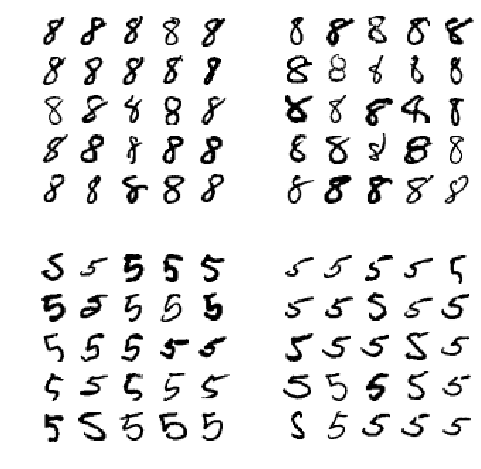

In [88]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 8, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [89]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [91]:
# Multioutput Classification
import numpy.random as rnd
X_train_mod = X_train + rnd.randint(0, 100, (len(X_train), 784))
X_test_mod = X_test + rnd.randint(0, 100, (len(X_test), 784))

y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

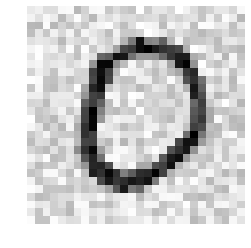

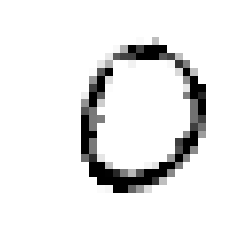

In [95]:
clean_digit = knn_clf.predict([X_test_mod[42]])

def plot_digit(d):
    img = d.reshape(28,28)
    plt.imshow(img, cmap = matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()
plot_digit(X_test_mod[42])
plot_digit(clean_digit)